# Importing needed Libraries

In [56]:
# import system libs
import os
from PIL import Image
import itertools

# import data handling tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.metrics import classification_report, confusion_matrix

# import Deep learning Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Flatten, Dense, BatchNormalization,Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras import callbacks

# Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

# Data Preprocessing

## Read data and store it in dataframe

### Train Data

In [2]:
# Generate train data paths with labels
train_data_dir  = '/kaggle/input/chest-xray-pneumonia/chest_xray/train'
filepaths = []
labels = []

folds = os.listdir(train_data_dir)

for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    
    for file in filelist:
        fpath = os.path.join(foldpath, file)
    
        filepaths.append(fpath)
        labels.append(fold)
        
# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= "filepaths")
Lseries = pd.Series(labels, name= "labels")
train_df = pd.concat([Fseries, Lseries], axis=1)

In [3]:
train_df

,filepaths,labels
0,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
1,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
2,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
3,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
4,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
...,...,...
5211,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL
5212,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL
5213,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL
5214,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL


### Valid Data

In [27]:
# Generate valid data paths with labels
valid_data_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/val'
filepaths = []
labels = []

folds = os.listdir(valid_data_dir)

for fold in folds:
    foldpath = os.path.join(valid_data_dir, fold)
    filelist = os.listdir(foldpath)
    
    for file in filelist:
        fpath = os.path.join(foldpath, file)
    
        filepaths.append(fpath)
        labels.append(fold)
        
# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= "filepaths")
Lseries = pd.Series(labels, name= "labels")
valid_df = pd.concat([Fseries, Lseries], axis=1)

In [28]:
valid_df

,filepaths,labels
0,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
1,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
2,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
3,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
4,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
5,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
6,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
7,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
8,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL
9,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL


### Test Data

In [29]:
# Generate test data paths with labels
test_data_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/test'
filepaths = []
labels = []

folds = os.listdir(test_data_dir)

for fold in folds:
    foldpath = os.path.join(test_data_dir, fold)
    filelist = os.listdir(foldpath)
    
    for file in filelist:
        fpath = os.path.join(foldpath, file)
    
        filepaths.append(fpath)
        labels.append(fold)
        
# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= "filepaths")
Lseries = pd.Series(labels, name= "labels")
test_df = pd.concat([Fseries, Lseries], axis=1)

In [30]:
test_df

,filepaths,labels
0,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
1,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
2,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
3,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
4,/kaggle/input/chest-xray-pneumonia/chest_xray/...,PNEUMONIA
...,...,...
619,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL
620,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL
621,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL
622,/kaggle/input/chest-xray-pneumonia/chest_xray/...,NORMAL


## Create image data generator

In [45]:
batch_size = 64
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='binary',
                                      color_mode='rgb', shuffle=True, batch_size=batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='binary',
                                      color_mode='rgb', shuffle=True, batch_size=batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='binary',
                                     color_mode='rgb', shuffle=False, batch_size=batch_size)

Found 5216 validated image filenames belonging to 2 classes.
Found 16 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


## Show sample from train data

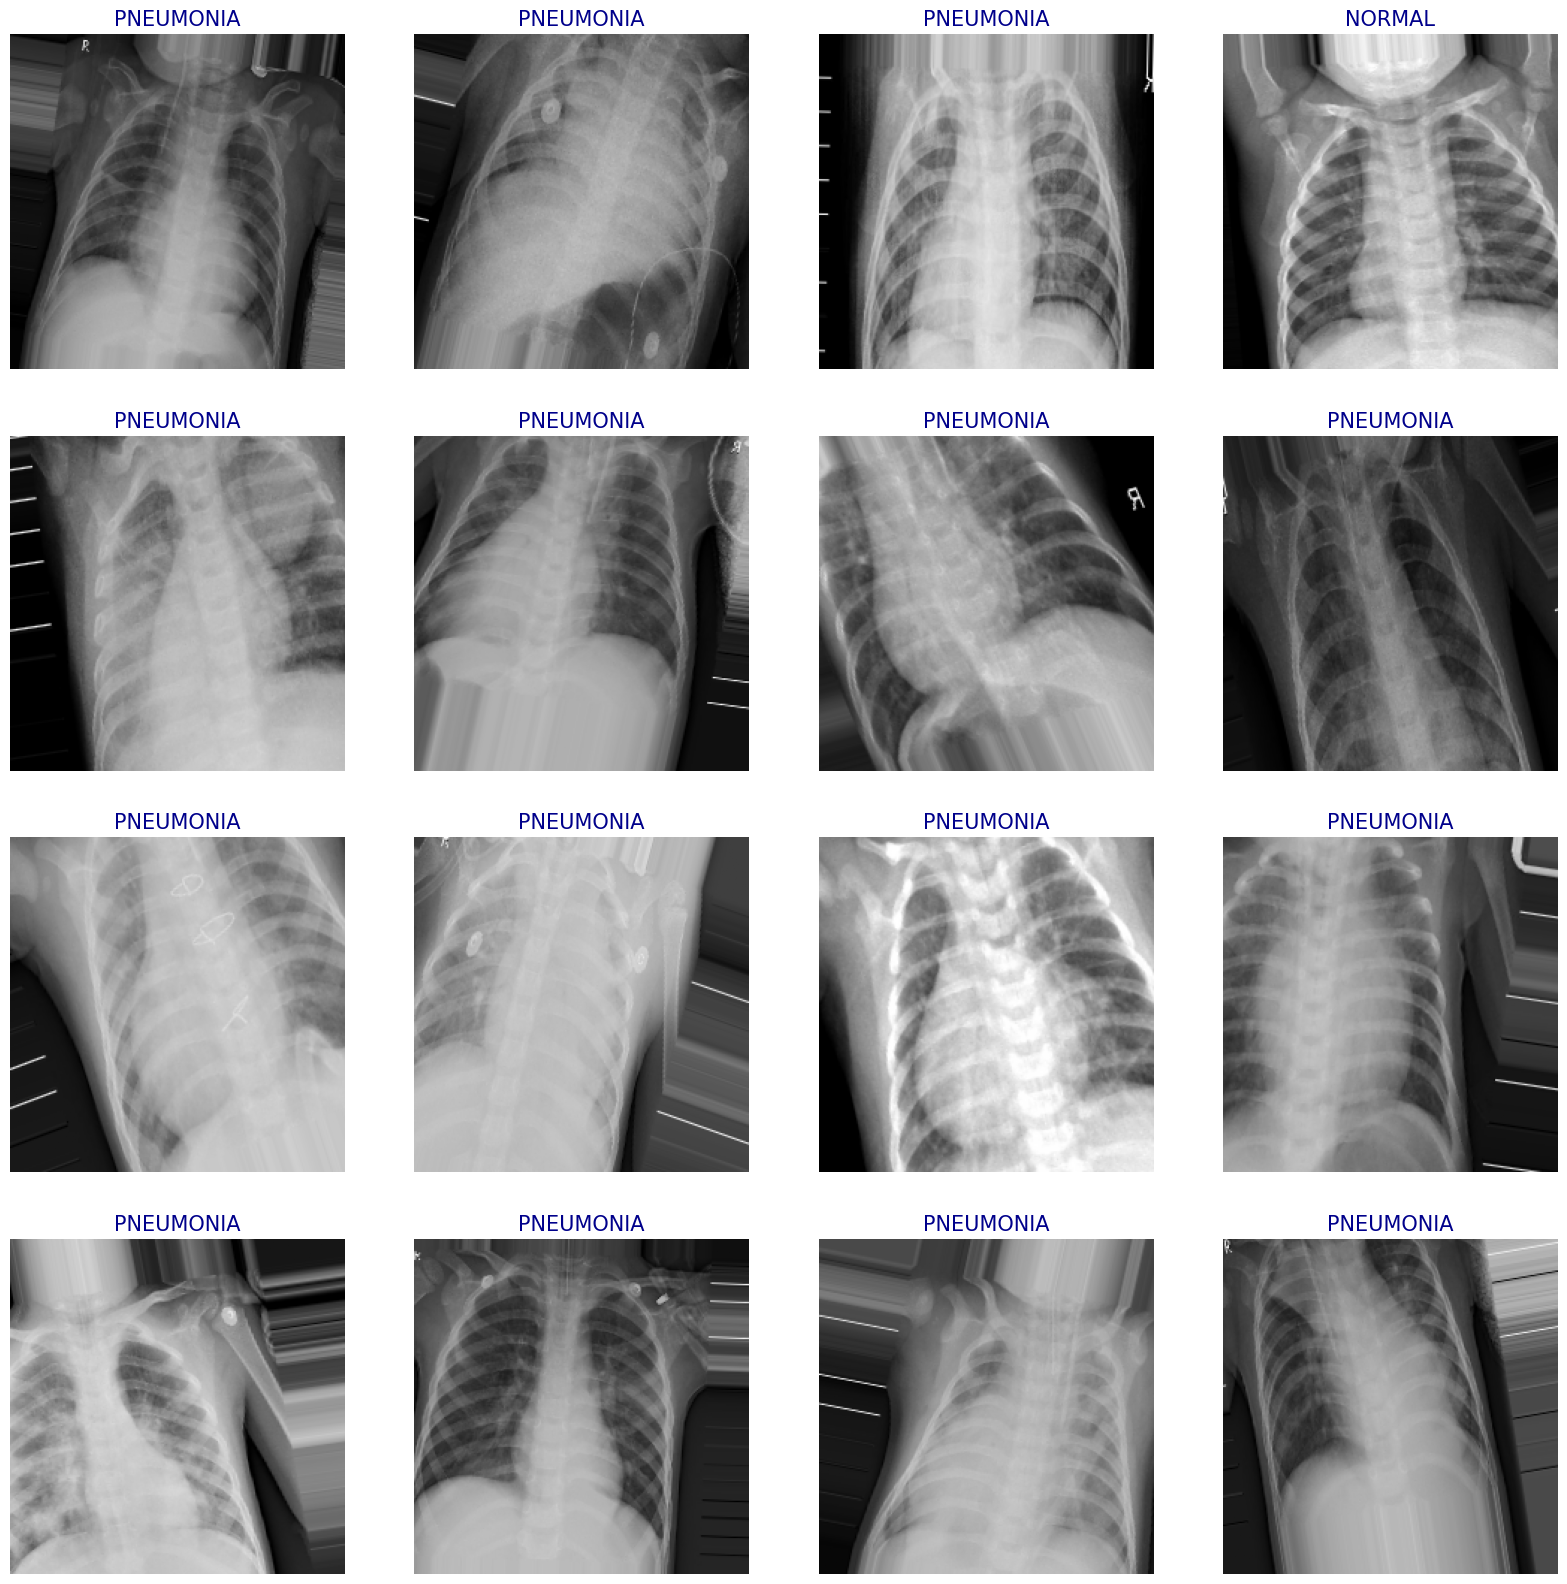

In [9]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize=(20, 20))

for i in range(16):
    plt.subplot(4, 4, i+1)
    image  = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = (labels[i].astype(int))  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color = 'darkblue', fontsize = 15)
    plt.axis('off')
plt.show()

# Model Structure

## Generic Model Creation

In [48]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

model = Sequential([
    
    # First Convolutional Block
    Conv2D(32, (3,3), padding='same', activation='relu', input_shape=img_shape),  #, input_shape=img_shape
    Conv2D(32, (3,3), padding='same', activation='relu'),
    MaxPooling2D((2,2)),
    
    # Second Convolutional Block
    Conv2D(64, (3,3), padding='same', activation='relu'),
    Conv2D(64, (3,3), padding='same', activation='relu'),
    MaxPooling2D((2,2)),
    
    
    # Third Convolutional Block
    Conv2D(128, (3,3), padding='same', activation='relu'),
    Conv2D(128, (3,3), padding='same', activation='relu'),
    Conv2D(128, (3,3), padding='same', activation='relu'),
    MaxPooling2D((2,2)),
    
    # Fourth Convolutional Block
    Conv2D(256, (3,3), padding='same', activation='relu'),
    Conv2D(256, (3,3), padding='same', activation='relu'),
    Conv2D(256, (3,3), padding='same', activation='relu'),
    MaxPooling2D((2,2)),
    
    Conv2D(512, (3,3), padding='same', activation='relu'),
    Conv2D(512, (3,3), padding='same', activation='relu'),
    Conv2D(512, (3,3), padding='same', activation='relu'),
    MaxPooling2D((2,2)),
    
    
    # Fully Connected Layers
    Flatten(),
    
    Dense(256, activation='relu'),  
    Dense(64, activation='relu'),    
    Dense(1, activation='sigmoid')     # Use 'sigmoid' for binary classification

])

# Compile the model
model.compile(Adamax(learning_rate=.001), loss = 'binary_crossentropy', metrics=['accuracy'])  # Binary crossentropy since it's a binary classification problem

# To display the summary
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_84 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_85 (Conv2D)              │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_86 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_87 (Conv2D)              │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_40 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_88 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_89 (Conv2D)              │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_90 (Conv2D)              │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_41 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_91 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_92 (Conv2D)              │ (None, 28, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_93 (Conv2D)              │ (None, 28, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_42 (MaxPooling2D) │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_94 (Conv2D)              │ (None, 14, 14, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_95 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_96 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_43 (MaxPooling2D) │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,248,993 (54.36 MB)

 Trainable params: 14,248,993 (54.36 MB)

 Non-trainable params: 0 (0.00 B)

## Train model

In [34]:
early_stopping = callbacks.EarlyStopping(
    patience=10,
    verbose=0,
    monitor='val_loss',
    mode='min',
    baseline = None,
    restore_best_weights = True,
    min_delta=0
)

plateau = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    mode='min',
    verbose=0,
    patience=4,
    factor=.2
)

In [49]:
history = model.fit(x = train_gen, epochs = 20, validation_data = valid_gen, 
                    shuffle = False, verbose = 1, callbacks = [early_stopping, plateau])

Epoch 1/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 61s 677ms/step - accuracy: 0.7003 - loss: 3.5357 - val_accuracy: 0.5000 - val_loss: 0.8625 - learning_rate: 0.0010
Epoch 2/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 45s 552ms/step - accuracy: 0.8363 - loss: 0.3369 - val_accuracy: 0.8750 - val_loss: 0.3345 - learning_rate: 0.0010
Epoch 3/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 46s 553ms/step - accuracy: 0.9386 - loss: 0.1613 - val_accuracy: 0.5625 - val_loss: 1.2101 - learning_rate: 0.0010
Epoch 4/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 47s 567ms/step - accuracy: 0.9591 - loss: 0.1047 - val_accuracy: 0.8750 - val_loss: 0.1979 - learning_rate: 0.0010
Epoch 5/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 45s 550ms/step - accuracy: 0.9716 - loss: 0.0761 - val_accuracy: 0.8750 - val_loss: 0.3097 - learning_rate: 0.0010
Epoch 6/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 46s 564ms/step - accuracy: 0.9832 - loss: 0.0556 - val_accuracy: 1.0000 - val_loss: 0.0312 - learning_rate: 0.0010
Epoch 7/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 45s 547ms/step - accuracy: 0.9807 - loss: 0.

## Display model performance

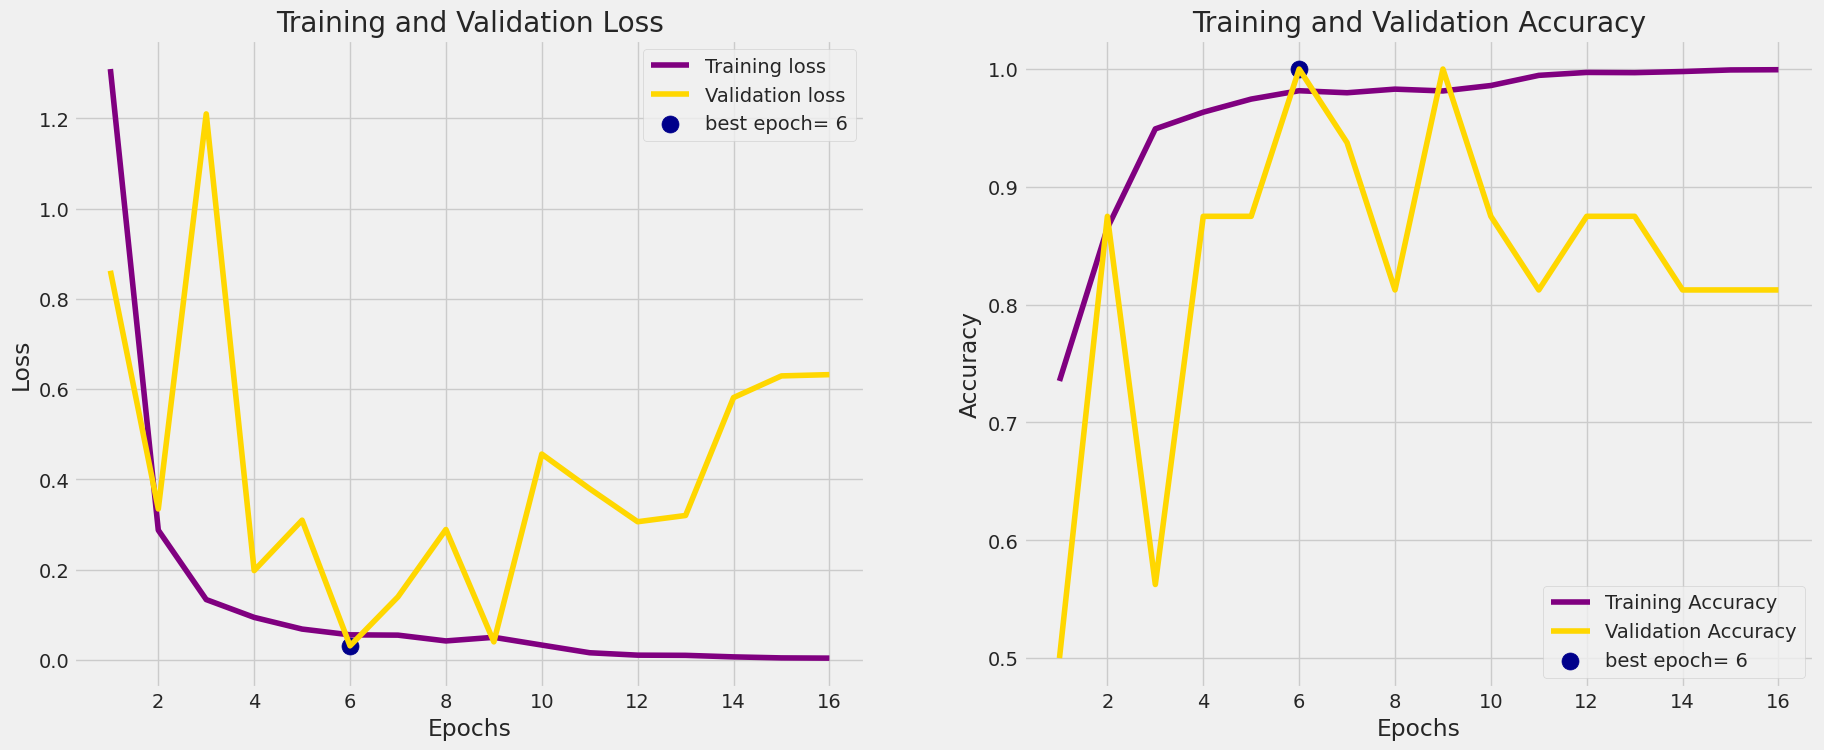

In [50]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'purple', label= 'Training loss')
plt.plot(Epochs, val_loss, 'gold', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'darkblue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'purple', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'gold', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'darkblue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

# Evaluate model

In [51]:
train_score = model.evaluate(train_gen, verbose= 1)
valid_score = model.evaluate(valid_gen, verbose= 1)
test_score = model.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

82/82 ━━━━━━━━━━━━━━━━━━━━ 46s 557ms/step - accuracy: 0.9749 - loss: 0.0668
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 1.0000 - loss: 0.0312
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.9230 - loss: 0.3063 
Train Loss:  0.07051237672567368
Train Accuracy:  0.973351240158081
--------------------
Valid Loss:  0.031151534989476204
Valid Accuracy:  1.0
--------------------
Test Loss:  0.7880710363388062
Test Accuracy:  0.8189102411270142


# Get Predictions

In [63]:
preds = model.predict(test_gen)
y_pred = preds > 0.5

10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 518ms/step


In [67]:
y_pred

array([[ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [

In [69]:
confusion_matrix(test_gen.classes, preds > 0.5)

array([[130, 104],
       [  9, 381]])

## Confusion Matrics and Classification Report

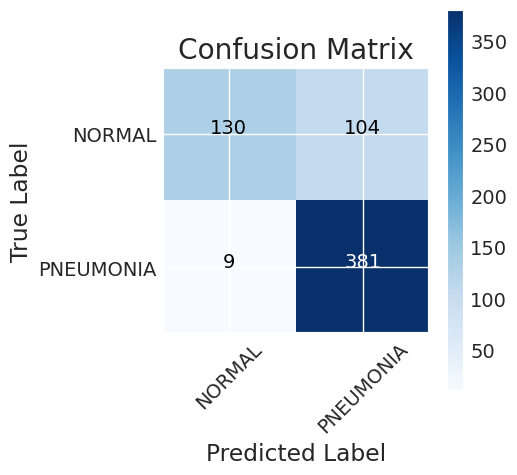

In [68]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (5, 5))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [70]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

      NORMAL       0.94      0.56      0.70       234
   PNEUMONIA       0.79      0.98      0.87       390

    accuracy                           0.82       624
   macro avg       0.86      0.77      0.78       624
weighted avg       0.84      0.82      0.81       624



## Save model

In [71]:
#Save the model
model.save('Model.h5')